In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

np.random.seed(42)

# הגדרות בסיס
n_users = 50000
start_date = datetime(2023, 1, 1)
end_date   = datetime(2024, 6, 30)  

# מייצרים משתמשים
user_ids = np.arange(1, n_users + 1)
signup_dates = [
    start_date + timedelta(days=int(x))
    for x in np.random.randint(0, (end_date - start_date).days // 3, size=n_users)
]

events = []
event_types = ["signup", "login", "deposit", "transaction", "session", "failed_payment", "card_usage"]

for user_id, signup in zip(user_ids, signup_dates):
    # האירוע הראשון תמיד signup
    events.append({
        "user_id": user_id,
        "signup_date": signup.date(),
        "event_date": signup.date(),
        "event_type": "signup"
    })
    
    # כמה שבועות קדימה נעקוב אחרי המשתמש (0–30 שבועות)
    weeks_active = np.random.randint(1, 30)
    
    for w in range(weeks_active):
        # כל שבוע יש סיכוי שיהיה אירוע
        current_week_date = signup + timedelta(weeks=w)
        if current_week_date > end_date:
            break
        
        # כמה אירועים באותו שבוע
        n_events_week = np.random.randint(0, 4)
        for _ in range(n_events_week):
            et = np.random.choice(
                event_types[1:],  # בלי signup
                p=[0.3, 0.15, 0.25, 0.2, 0.05, 0.05]  # הסתברויות שונות
            )
            events.append({
                "user_id": user_id,
                "signup_date": signup.date(),
                "event_date": current_week_date.date(),
                "event_type": et
            })

df_events = pd.DataFrame(events)
df_events.head()


,user_id,signup_date,event_date,event_type
0,1,2023-04-13,2023-04-13,signup
1,1,2023-04-13,2023-04-13,login
2,1,2023-04-13,2023-04-13,login
3,1,2023-04-13,2023-04-13,deposit
4,1,2023-04-13,2023-04-20,login


In [3]:
df_events.to_csv("fintech_weekly_events.csv", index=False)


In [4]:
df_events['signup_date'] = pd.to_datetime(df_events['signup_date'])
df_events['event_date'] = pd.to_datetime(df_events['event_date'])

df_events["cohort_week"] = df_events["signup_date"].dt.isocalendar().week # שבוע ההרשמה
df_events["event_week"] = ((df_events["event_date"] - df_events["signup_date"]).dt.days // 7) #השבוע שבו התרחש האירוע לעומת שבוע ההרשמה
df_events.head()


,user_id,signup_date,event_date,event_type,cohort_week,event_week
0,1,2023-04-13,2023-04-13,signup,15,0
1,1,2023-04-13,2023-04-13,login,15,0
2,1,2023-04-13,2023-04-13,login,15,0
3,1,2023-04-13,2023-04-13,deposit,15,0
4,1,2023-04-13,2023-04-20,login,15,1


In [7]:
df_events = df_events[df_events["event_week"] >= 0 ] # נזהר שלא לספור event_week שליליים

# טבלת Retention
cohort_pivot = (
    df_events
    .groupby(["cohort_week", "event_week"])["user_id"]
    .nunique()
    .unstack(fill_value=0))

cohort_pivot.head()

event_week,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
cohort_week,,,,,,,,,,,,,,,,,,,,,
1,1887,1381,1358,1286,1242,1188,1140,1102,1060,1006,...,496,464,422,373,323,276,224,170,113,33
2,1949,1434,1372,1287,1260,1184,1137,1089,1090,996,...,512,457,402,335,305,225,188,131,88,42
3,1970,1415,1370,1358,1293,1228,1196,1134,1089,1043,...,498,477,421,348,310,255,200,152,92,50
4,1952,1426,1365,1342,1254,1194,1149,1119,1089,1027,...,504,463,400,361,294,255,197,148,100,60
5,1858,1353,1321,1250,1193,1160,1105,1089,986,957,...,469,422,360,318,274,238,172,133,86,50


In [8]:
# חישוב שיעורי שימור
cohort_size = cohort_pivot.iloc[:,0]  # כמות הנרשמים בשבוע 0
retention = cohort_pivot.divide(cohort_size, axis=0)
retention

event_week,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
cohort_week,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.731849,0.719661,0.681505,0.658188,0.629571,0.604134,0.583996,0.561738,0.533121,...,0.262851,0.245893,0.223635,0.197668,0.171171,0.146264,0.118707,0.090090,0.059883,0.017488
2,1.0,0.735762,0.703951,0.660339,0.646485,0.607491,0.583376,0.558748,0.559261,0.511031,...,0.262699,0.234479,0.206260,0.171883,0.156491,0.115444,0.096460,0.067214,0.045151,0.021550
3,1.0,0.718274,0.695431,0.689340,0.656345,0.623350,0.607107,0.575635,0.552792,0.529442,...,0.252792,0.242132,0.213706,0.176650,0.157360,0.129442,0.101523,0.077157,0.046701,0.025381
4,1.0,0.730533,0.699283,0.687500,0.642418,0.611680,0.588627,0.573258,0.557889,0.526127,...,0.258197,0.237193,0.204918,0.184939,0.150615,0.130635,0.100922,0.075820,0.051230,0.030738
5,1.0,0.728202,0.710980,0.672766,0.642088,0.624327,0.594726,0.586114,0.530678,0.515070,...,0.252422,0.227126,0.193757,0.171152,0.147470,0.128095,0.092573,0.071582,0.046286,0.026911
6,1.0,0.727662,0.698769,0.653826,0.643125,0.608347,0.587480,0.551097,0.539861,0.509898,...,0.241306,0.224719,0.189941,0.163189,0.147138,0.124131,0.097913,0.069021,0.048154,0.020332
7,1.0,0.724458,0.697110,0.673891,0.654799,0.604231,0.590815,0.571723,0.534056,0.528380,...,0.240970,0.216718,0.203818,0.174407,0.156347,0.125903,0.101651,0.074303,0.044892,0.025284
8,1.0,0.722923,0.700315,0.668770,0.663512,0.638801,0.601472,0.586225,0.556257,0.527340,...,0.263933,0.230284,0.210305,0.182965,0.156151,0.123028,0.095689,0.067823,0.048896,0.022608
9,1.0,0.725000,0.689286,0.667857,0.645408,0.619898,0.584694,0.567347,0.531122,0.512245,...,0.244898,0.217857,0.192857,0.158163,0.151020,0.119388,0.096939,0.071429,0.042347,0.020408


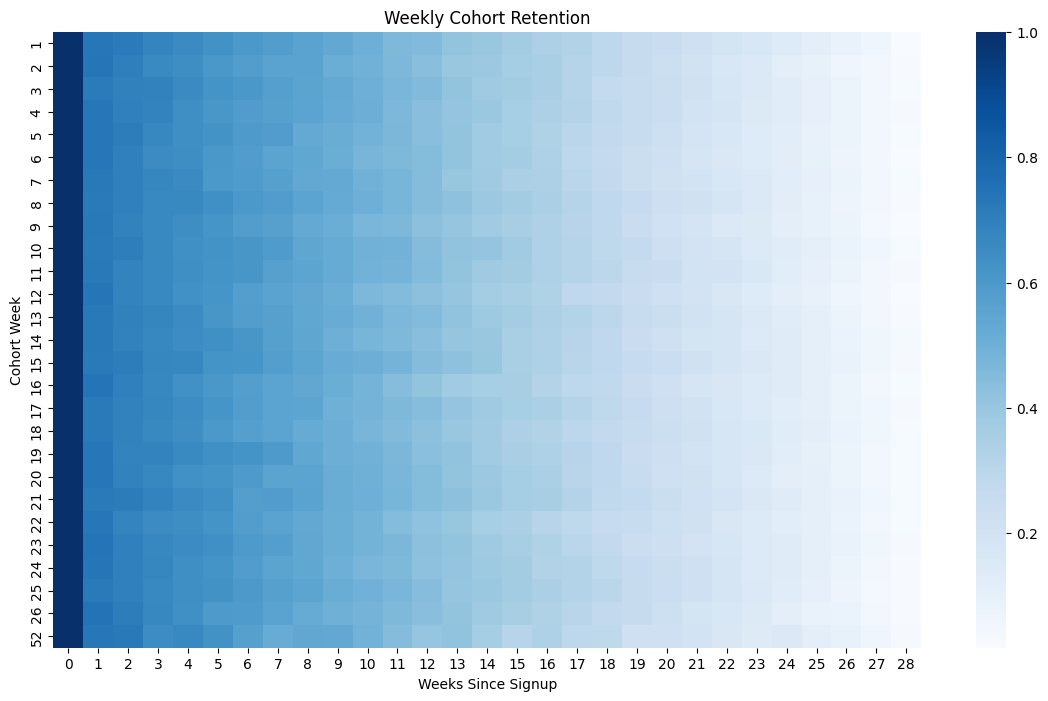

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,8))
sns.heatmap(retention, cmap="Blues", annot=False)
plt.title("Weekly Cohort Retention")
plt.xlabel("Weeks Since Signup")
plt.ylabel("Cohort Week")
plt.show()


##  Insights – Weekly Retention Analysis

# מעבר על פי שבועות
המעבר משבוע0 לשבוע1 הוא הכי קריטי כי רוב המשתמשים מאבדים עניין מיד לאחר ההרשמה. 

משבוע3 ואילך הירידה יותר מתונה - אלו שנשארו 3 שבועות הם כנראה "משתמשי ליבה" באפליקציה

הצבעים דומים לרוחב -> אין חודשים חזקים/חלשים -> יציבות

המשתמשים ש"שרדו" עד שבוע 4 נוטים להישאר עד שבוע 8 - אלו המשתמשים שמייצרים כסף אמיתי. 


# צריך לשפר את שבוע1
איך? 
הצעת תמריצים כמו בונוסים/קשבק, הוספת תזכורות, פיצ'רים שמחזירים משתמשים ביום-יומיים הראשונים
לכן ההמלצה- להשקיע בפיצקר שמחזיר משתמש לאחר יומיים


